In [44]:
import numpy as np
from scipy.optimize import root_scalar, root
import matplotlib.pyplot as plt 
from numpy.linalg import eigvals
from scipy.optimize import minimize
from scipy.optimize import fsolve

In [45]:
def first_eqs(t, m, s, u):
    # ensure python float for stability
    s = float(s)  
    t = float(t)
    m = float(m)
    u = float(u) 

    # clip exponent arguments to avoid overflow
    # choose safe_clip = 700 for np.exp (np.exp(700) ~ 1e304) 
    safe_clip = 700.0 
    a = 9 * s / (4 * t) 
    b = m / t 
    c = (3 * s + 4 * u)/(4 * t) 
    a = np.clip(a, -safe_clip, safe_clip)
    b = np.clip(b, -safe_clip, safe_clip)
    c = np.clip(c, -safe_clip, safe_clip)
    
    exp1 = np.exp(a) 
    exp2 = np.exp(c)
    cosh = np.cosh(b) 

    denom =  2 + exp1 * cosh + 3 * exp2 * (2 + cosh)
    
    # avoid division by zero
    if denom == 0:
        return 1e6
    
    return s + (1 - exp1 * cosh)/denom

def second_eqs(t, m, s, u):
    # ensure python float for stability
    s = float(s)  
    t = float(t)
    m = float(m) 
    u = float(u)

    # clip exponent arguments to avoid overflow
    # choose safe_clip = 700 for np.exp (np.exp(700) ~ 1e304) 
    safe_clip = 700.0 
    a = 3 * s / (2 * t)
    b = m / t
    c = - u / t
    a = np.clip(a, -safe_clip, safe_clip)
    b = np.clip(b, -safe_clip, safe_clip)
    c = np.clip(c, -safe_clip, safe_clip) 

    exp1 = np.exp(a) 
    exp2 = np.exp(-a / 2) 
    exp3 = np.exp(c)
    cosh = np.cosh(b) 
    sinh = np.sinh(b) 
    tanh = np.tanh(b)

    denom = 6 * (2 + cosh) + 2 * exp3 * (2 * exp2 + exp1 * cosh)
    # avoid division by zero
    if denom == 0:
        return 1e6 

    return m - t * (6 * sinh/t + 2*exp1*exp3*sinh/t)/denom
 

def bound_equations(t, u, vars_): 
    m, s = vars_
    return [first_eqs(t, m, s, u) , second_eqs(t, m, s, u)]

def hessian(t, m, s, u): 
    # ensure python float for stability
    s = float(s)  
    t = float(t)
    m = float(m) 
    u = float(u) 

    safe_clip = 700.0
    a = (9/4) * s / t
    b = m / t
    c = (3 * s + 4 * u)/(4 * t) 
    d = u / t 
    e = (3 * s - 2 * u)/(2 * t) 
    a = np.clip(a, -safe_clip, safe_clip)
    b = np.clip(b, -safe_clip, safe_clip)
    c = np.clip(c, -safe_clip, safe_clip)
    d = np.clip(d, -safe_clip, safe_clip) 
    e = np.clip(e, -safe_clip, safe_clip) 


    #precompute recurring terms with safe clip
    exp1 = np.exp(a) # exp(9s/4t)
    exp2 = np.exp(c) # exp(3s + 4u)/(4t) 
    exp3 = np.exp(a / 3) # exp(3s/4t)
    exp4 = np.exp((2/3)*a) # exp(3s/2t)
    exp5 = np.exp(d) # exp(u/t)
    exp6 = np.exp(-c) # exp( - (3s + 4u)/(4t))
    exp7 = np.exp(e) # exp(3s - 2u)/(2t)
    cosh = np.cosh(b) 
    sinh = np.sinh(b) 

    #common denominators
    denom1 = 2 + exp1*cosh + 3*exp2*(2+cosh)
    denom2 = -2*t + (-1 + (1- exp1)/(1+3*exp2))*t*cosh
    denom3 = t*cosh + (2*t)/(1+ (-1 + exp1)/(1+3*exp2))
    denom4 = 4*(3+exp6) + 2*(3+exp7)*cosh

    # guard denominators
    denom1 = np.maximum(denom1, 1e-300) 
    denom2 = np.maximum(denom2, 1e-300)
    denom3 = np.maximum(denom3, 1e-300) 
    denom4 = np.maximum(denom4, 1e-300) 

    #individual Hessian elements 
    H11 = 1 + (exp1*cosh - 1)*(exp1*cosh - 1)/(4*t*denom1*denom1) - (exp1*cosh + 5)/(4*t*denom1)
    H12 = (9 - 3*exp2*(2+cosh)*(exp1*cosh - 4))/(4*t*denom1*denom1)
    H13 = (9*exp1*cosh + 3*exp2*(2+cosh)*(1+2*exp1*cosh))/(4*t*denom1*denom1) 
    H16 = (3*exp3*(exp4 + exp5*(1+2*exp1))*sinh)/(2*t*denom1*denom1) 
    H33 = 1 + (exp1*cosh - 1)*(exp1*cosh - 1)/(t*denom1*denom1) - (1 + 2*exp1*cosh)/(2*t*denom1)
    H36 = -(3*exp3*(exp4 + exp5*(1+2*exp1))*sinh)/(t*denom1*denom1)  
    H44 = 1 + 1/denom2
    H66 = 1 - cosh/denom3 + (4*(3+exp7)*(3+exp7)*sinh*sinh)/(t*denom4*denom4)

    # full Hessian matrix 
    hessian_matrix = np.array([
        [H11, H12, H13, 0.0, 0.0, H16],
        [H12, H11, H13, 0.0, 0.0, H16],
        [H13, H13, H33, 0.0, 0.0, H36],
        [0.0, 0.0, 0.0, H44, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, H44, 0.0],
        [H16, H16, H36, 0.0, 0.0, H66]
    ])

    # make symmetric
    hessian_matrix = 0.5 * (hessian_matrix + hessian_matrix.T)

    return hessian_matrix


def stability_check(t, m, s, u, tol=-1e-9):
    
    #return False (unstable / not defined) if any input is NaN or not finite
    if not (np.isfinite(t) and np.isfinite(m) and np.isfinite(S)):
        return False
    
    H = hessian(t, m, S, u)

    # check the matrix itself
    if not np.all(np.isfinite(H)):
        return False
    
    e = np.real_if_close(eigvals(H))
    # require all eigenvalues strictly greater than tol
    return np.all(e > tol)


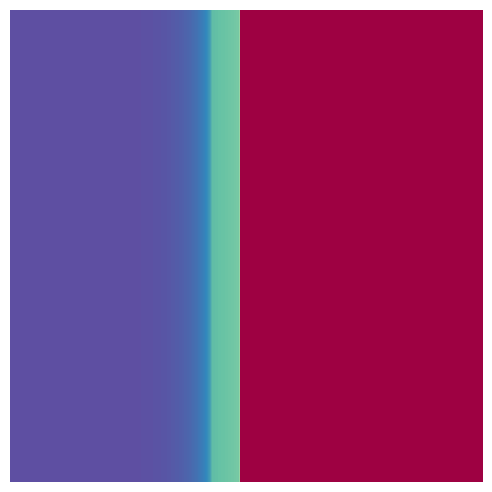

In [57]:
T_vals = np.linspace(0.01, 1.00, 500)
S_vals = []  
m_vals = []
n = len(T_vals) 

u = 0.01

for t in T_vals:

    sol = root(lambda vars_: bound_equations(t, u, vars_), [S_vals[-1] if S_vals else 1.0, m_vals[-1] if m_vals else 1.0])  
    if sol.success: 
        S_vals.append(sol.x[0])
        m_vals.append(sol.x[1]) 
    else: 
        # Try fallback 
        sol = root(lambda vars_: bound_equations(t, u, vars_), [S_vals[-1] if S_vals else 1.0, m_vals[-1] if m_vals else 1.0], method = 'lm') 
        if sol.success: 
            S_vals.append(sol.x[0])
            m_vals.append(sol.x[1]) 
        else: 
            S_vals.append(np.nan)
            m_vals.append(np.nan)  

stability_map = np.full((n, n), 0, dtype=float)

for line, m in enumerate(m_vals):
    for column, (t, S) in enumerate(zip(T_vals, S_vals)):
        #if stability_check(t, (m, S)):
        #    stability_map[line, column] = S  # Only assign if stable 
        stability_map[line, column] = S

np.savetxt('Diluted_Stability_map.txt', stability_map, delimiter=' ', fmt='%f') 

data = np.loadtxt("Diluted_Stability_map.txt")
data = np.ma.masked_invalid(data) 

cmap='Spectral'
cm = 1/2.54
plt.figure(figsize=(12*cm, 12*cm))  # Adjust for output size in cm
plt.imshow(data, origin='lower', cmap=cmap, extent=[0, 500, 0, 500])
plt.axis('off') 
plt.tight_layout(pad=0)
plt.savefig("Diluted_heatmap.png", dpi=600, bbox_inches='tight', pad_inches=0, transparent=True)

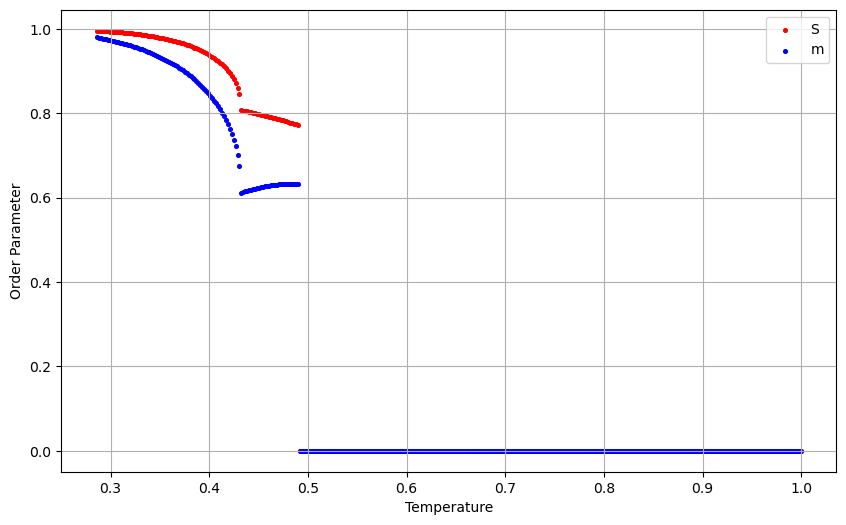

In [58]:
t_stable, s_stable, m_stable, u_stable = [], [], [], [] 

for i in range(len(T_vals)): 
    if stability_check(T_vals[i], m_vals[i] ,S_vals[i], u):
        t_stable.append(T_vals[i]) 
        s_stable.append(S_vals[i])  
        m_stable.append(m_vals[i])   


# Plot
fig=plt.figure(figsize=(10, 6))

plt.scatter(t_stable, s_stable, label=f'S', color='red',s=7)
plt.scatter(t_stable, m_stable, label=f'm', color='blue',s=7) 

plt.xlabel('Temperature')
plt.ylabel('Order Parameter')
plt.legend()
plt.grid(True) 
plt.show() 